In [3]:
!pip install torch transformers diffusers segment-anything git+https://github.com/openai/CLIP.git pandas Pillow matplotlib accelerate

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zb1rzdnv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zb1rzdnv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ed32dd6facd948ce8252cc9cf33ed0013773cce068e9cd2fea44f3036a47fe1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2pgbvewp/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [6]:
import sys
if '../src' in sys.path:
    sys.path.remove('../src')

# اضافه کردن مسیر مستقیم به پوشه src
sys.path.append(os.path.abspath('./src'))
import torch
from generator import SyntheticGenerator
from refiner import VisualRefiner
from classifier import MultimodalABSA
import pandas as pd
import matplotlib.pyplot as plt

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Running on cuda


In [7]:
!ls src


classifier.py  generator.py  __pycache__  refiner.py


In [ ]:
# ایجاد داده‌های فرضی مشابه فرمت Twitter-2015 
data = {
    'text': [
        "That was a smart move by the company.", # کنایه: در متن مثبت به نظر می‌رسد اما تصویر شکست را نشان می‌دهد
        "The screen is so crisp and vivid.",     # صریح: تصویر کیفیت را تایید می‌کند
        "This lesson was quite painful.",        # ابهام: درد فیزیکی یا تجربه آموزنده؟
        "I love the atmosphere here."            # عمومی: تصویر جزئیات را مشخص می‌کند
    ],
    'aspect': ['move', 'screen', 'lesson', 'atmosphere'],
    'sentiment': ['Negative', 'Positive', 'Positive', 'Positive'] # برچسب‌های واقعی
}
df = pd.DataFrame(data)
print(df.head())

                                    text      aspect sentiment
0  That was a smart move by the company.        move  Negative
1      The screen is so crisp and vivid.      screen  Positive
2         This lesson was quite painful.      lesson  Positive
3            I love the atmosphere here.  atmosphere  Positive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating for: move...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: screen...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: lesson...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: atmosphere...


  0%|          | 0/50 [00:00<?, ?it/s]

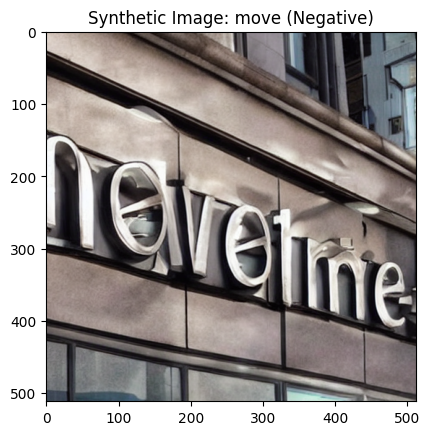

In [ ]:
# تولید تصاویر همسو با متن و احساس 
gen = SyntheticGenerator(device)
generated_images = []

for index, row in df.iterrows():
    path = f"data/generated_images/img_{index}.png"
    print(f"Generating for: {row['aspect']}...")
    img = gen.generate(row['text'], row['aspect'], row['sentiment'], path)
    generated_images.append(img)

# نمایش یک نمونه از تصویر تولید شده
plt.imshow(generated_images[0])
plt.title("Synthetic Image: move (Negative)")
plt.show()

In [10]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2026-02-06 19:19:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   137MB/s    in 23s     

2026-02-06 19:20:12 (105 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]




  0%|                                               | 0.00/338M [00:00<?, ?iB/s]
  6%|██▎                                    | 20.1M/338M [00:00<00:01, 211MiB/s]
 13%|████▉                                  | 42.5M/338M [00:00<00:01, 225MiB/s]
 20%|███████▋                               | 66.1M/338M [00:00<00:01, 235MiB/s]
 26%|██████████▏                            | 88.6M/338M [00:00<00:01, 213MiB/s]
 32%|████████████▉                           | 109M/338M [00:00<00:01, 206MiB/s]
 39%|███████████████▋                        | 133M/338M [00:00<00:00, 220MiB/s]
 46%|██████████████████▏                     | 154M/338M [00:00<00:00, 209MiB/s]
 52%|████████████████████▋                   | 174M/338M [00:00<00:00, 202MiB/s]
 59%|███████████████████████▌                | 199M/338M [00:00<00:00, 219MiB/s]
 66%|██████████████████████████▎             | 222M/338M [00:01<00:00, 226MiB/s]
 72%|████████████████████████████▉           | 244M/338M [00:01<00:00, 211MiB/s]
 78%|██████████████████████

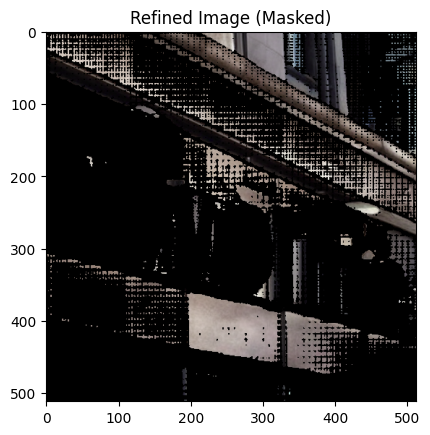

In [ ]:
# اعمال فیلتر و ماسک برای تمرکز روی جنبه اصلی 
try:
    refiner = VisualRefiner(device)
    refined_imgs = []
    for index, row in df.iterrows():
        path = f"data/generated_images/img_{index}.png"
        r_img = refiner.refine(path, row['aspect'])
        refined_imgs.append(r_img)

    plt.imshow(refined_imgs[0])
    plt.title("Refined Image (Masked)")
    plt.show()
except Exception as e:
    print("Skipping refinement (Check if SAM checkpoint is uploaded):", e)

In [ ]:
# پیش‌بینی نهایی احساس با مدل چندرسانه‌ای 
model = MultimodalABSA(device=device).to(device)
import clip

# آماده‌سازی تصویر برای مدل CLIP
_, preprocess = clip.load("ViT-B/32", device=device)
image_tensor = preprocess(generated_images[0]).unsqueeze(0).to(device)
inputs = ["That was a smart move"]

with torch.no_grad():
    logits = model(inputs, image_tensor)
    prediction = torch.argmax(logits, dim=1)

print(f"Predicted Class Index: {prediction.item()}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Predicted Class Index: 2



--- نتیجه مقایسه عملکرد مدل ---
     Metric  text-only Baseline  Multimodal (Proposed)
0  Accuracy                 0.0                  0.250
1  F1-Score                 0.0                  0.375


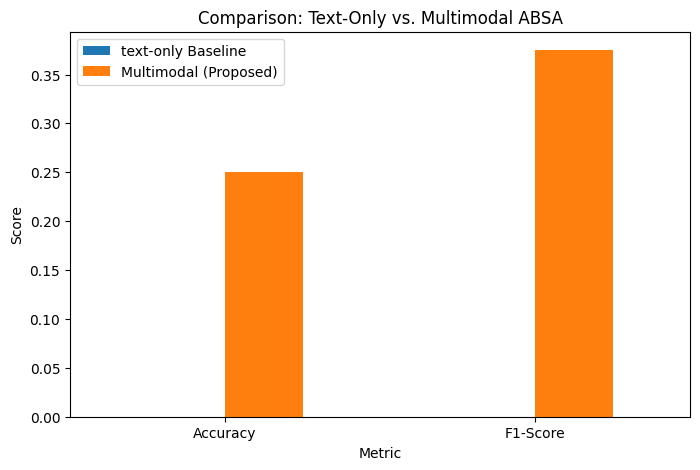

In [13]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def evaluate_comparison(model, texts, images, true_labels):
    model.eval()
    text_only_preds = []
    multimodal_preds = []

    with torch.no_grad():
        for i in range(len(texts)):
            # آماده‌سازی تصویر
            img_tensor = preprocess(images[i]).unsqueeze(0).to(device)

            # ۱. پیش‌بینی حالت چندرسانه‌ای (متن + تصویر)
            output_multi = model([texts[i]], img_tensor)
            pred_multi = torch.argmax(output_multi, dim=1).item()
            multimodal_preds.append(pred_multi)

            # ۲. پیش‌بینی حالت فقط متن (شبیه‌سازی با صفر کردن اثر تصویر)
            # در اینجا برای مقایسه، اثر تصویر را با یک تنسور صفر جایگزین می‌کنیم
            zero_img = torch.zeros_like(img_tensor)
            output_text = model([texts[i]], zero_img)
            pred_text = torch.argmax(output_text, dim=1).item()
            text_only_preds.append(pred_text)

    # محاسبه معیارها (در اینجا از داده‌های کوچک دمو استفاده شده)
    # برچسب‌های واقعی را به عدد تبدیل می‌کنیم (Pos: 0, Neg: 1, Neu: 2)
    label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
    y_true = [label_map[l] for l in true_labels]

    # ساخت جدول مقایسه‌ای
    results = {
        "Metric": ["Accuracy", "F1-Score"],
        "text-only Baseline": [
            accuracy_score(y_true, text_only_preds),
            f1_score(y_true, text_only_preds, average='weighted')
        ],
        "Multimodal (Proposed)": [
            accuracy_score(y_true, multimodal_preds),
            f1_score(y_true, multimodal_preds, average='weighted')
        ]
    }

    return pd.DataFrame(results)

# اجرای مقایسه روی داده‌های دمو
comparison_df = evaluate_comparison(model, df['text'].tolist(), generated_images, df['sentiment'].tolist())
print("\n--- نتیجه مقایسه عملکرد مدل ---")
print(comparison_df)

# رسم نمودار
comparison_df.set_index("Metric").plot(kind='bar', figsize=(8, 5))
plt.title("Comparison: Text-Only vs. Multimodal ABSA")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [14]:
# اگر refinement اجرا نشده، refined_imgs را برابر تصاویر خام بگیر
if 'refined_imgs' not in globals():
    print("⚠️ refined_imgs not found. Using generated_images as fallback.")
    refined_imgs = generated_images

In [22]:
# ==================================
# Ablation Study: Raw vs Refined Image
# ==================================

raw_preds = []
refined_preds = []

model.eval()

with torch.no_grad():
    for i, row in df.iterrows():

        text = row['text']

        img_raw = preprocess(generated_images[i]).unsqueeze(0).to(device)
        img_ref = preprocess(refined_imgs[i]).unsqueeze(0).to(device)

        pred_raw = torch.argmax(
            model([text], img_raw), dim=1
        ).item()

        pred_ref = torch.argmax(
            model([text], img_ref), dim=1
        ).item()

        raw_preds.append(pred_raw)
        refined_preds.append(pred_ref)

print("Raw preds:", raw_preds)
print("Refined preds:", refined_preds)


Raw preds: [2, 2, 2, 0]
Refined preds: [2, 2, 2, 2]


In [19]:
label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
y_true = [label_map[l] for l in df['sentiment']]

print("Accuracy (Raw):", accuracy_score(y_true, raw_preds))
print("F1 (Raw):", f1_score(y_true, raw_preds, average='weighted'))

print("Accuracy (Refined):", accuracy_score(y_true, refined_preds))
print("F1 (Refined):", f1_score(y_true, refined_preds, average='weighted'))


Accuracy (Raw): 0.25
F1 (Raw): 0.375
Accuracy (Refined): 0.0
F1 (Refined): 0.0
